## Введение


Вы — специалист по Data Science в каршеринговой компании. Вам поступил заказ: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.
Идея решения задачи от заказчика: 

1. Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
     
    1. Для модели выбрать тип виновника — только машина (car).
    2. Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
    3. Для моделирования ограничиться данными за 2012 год — они самые свежие.
    4. Обязательное условие — учесть фактор возраста автомобиля.
2. На основе модели исследовать основные факторы ДТП.
3. Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
     
    1. Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
    2. Какие ещё факторы нужно учесть?
    3. Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

Заказчик предлагает вам поработать с базой данных по происшествиям и сформировать свои идеи создания такой системы. 

## Подключитение к БД. Загрузка таблицы sql

In [1]:
!pip install category_encoders

In [2]:
!pip install lightgbm

In [3]:
!pip install -U scikit-learn

In [4]:
!pip install SQLAlchemy

In [5]:
!pip install psycopg2-binary

In [6]:
import matplotlib
import sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import lightgbm as lgb

from sqlalchemy import create_engine
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [7]:
sklearn.__version__

'1.5.0'

In [8]:
db_config = {
'user': 'XXX', 
'pwd': 'XXX', 
'host': 'XXX',
'port': 0000, 
'db': 'XXX' 
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [9]:
engine = create_engine(connection_string)

## Первичное исследование таблиц

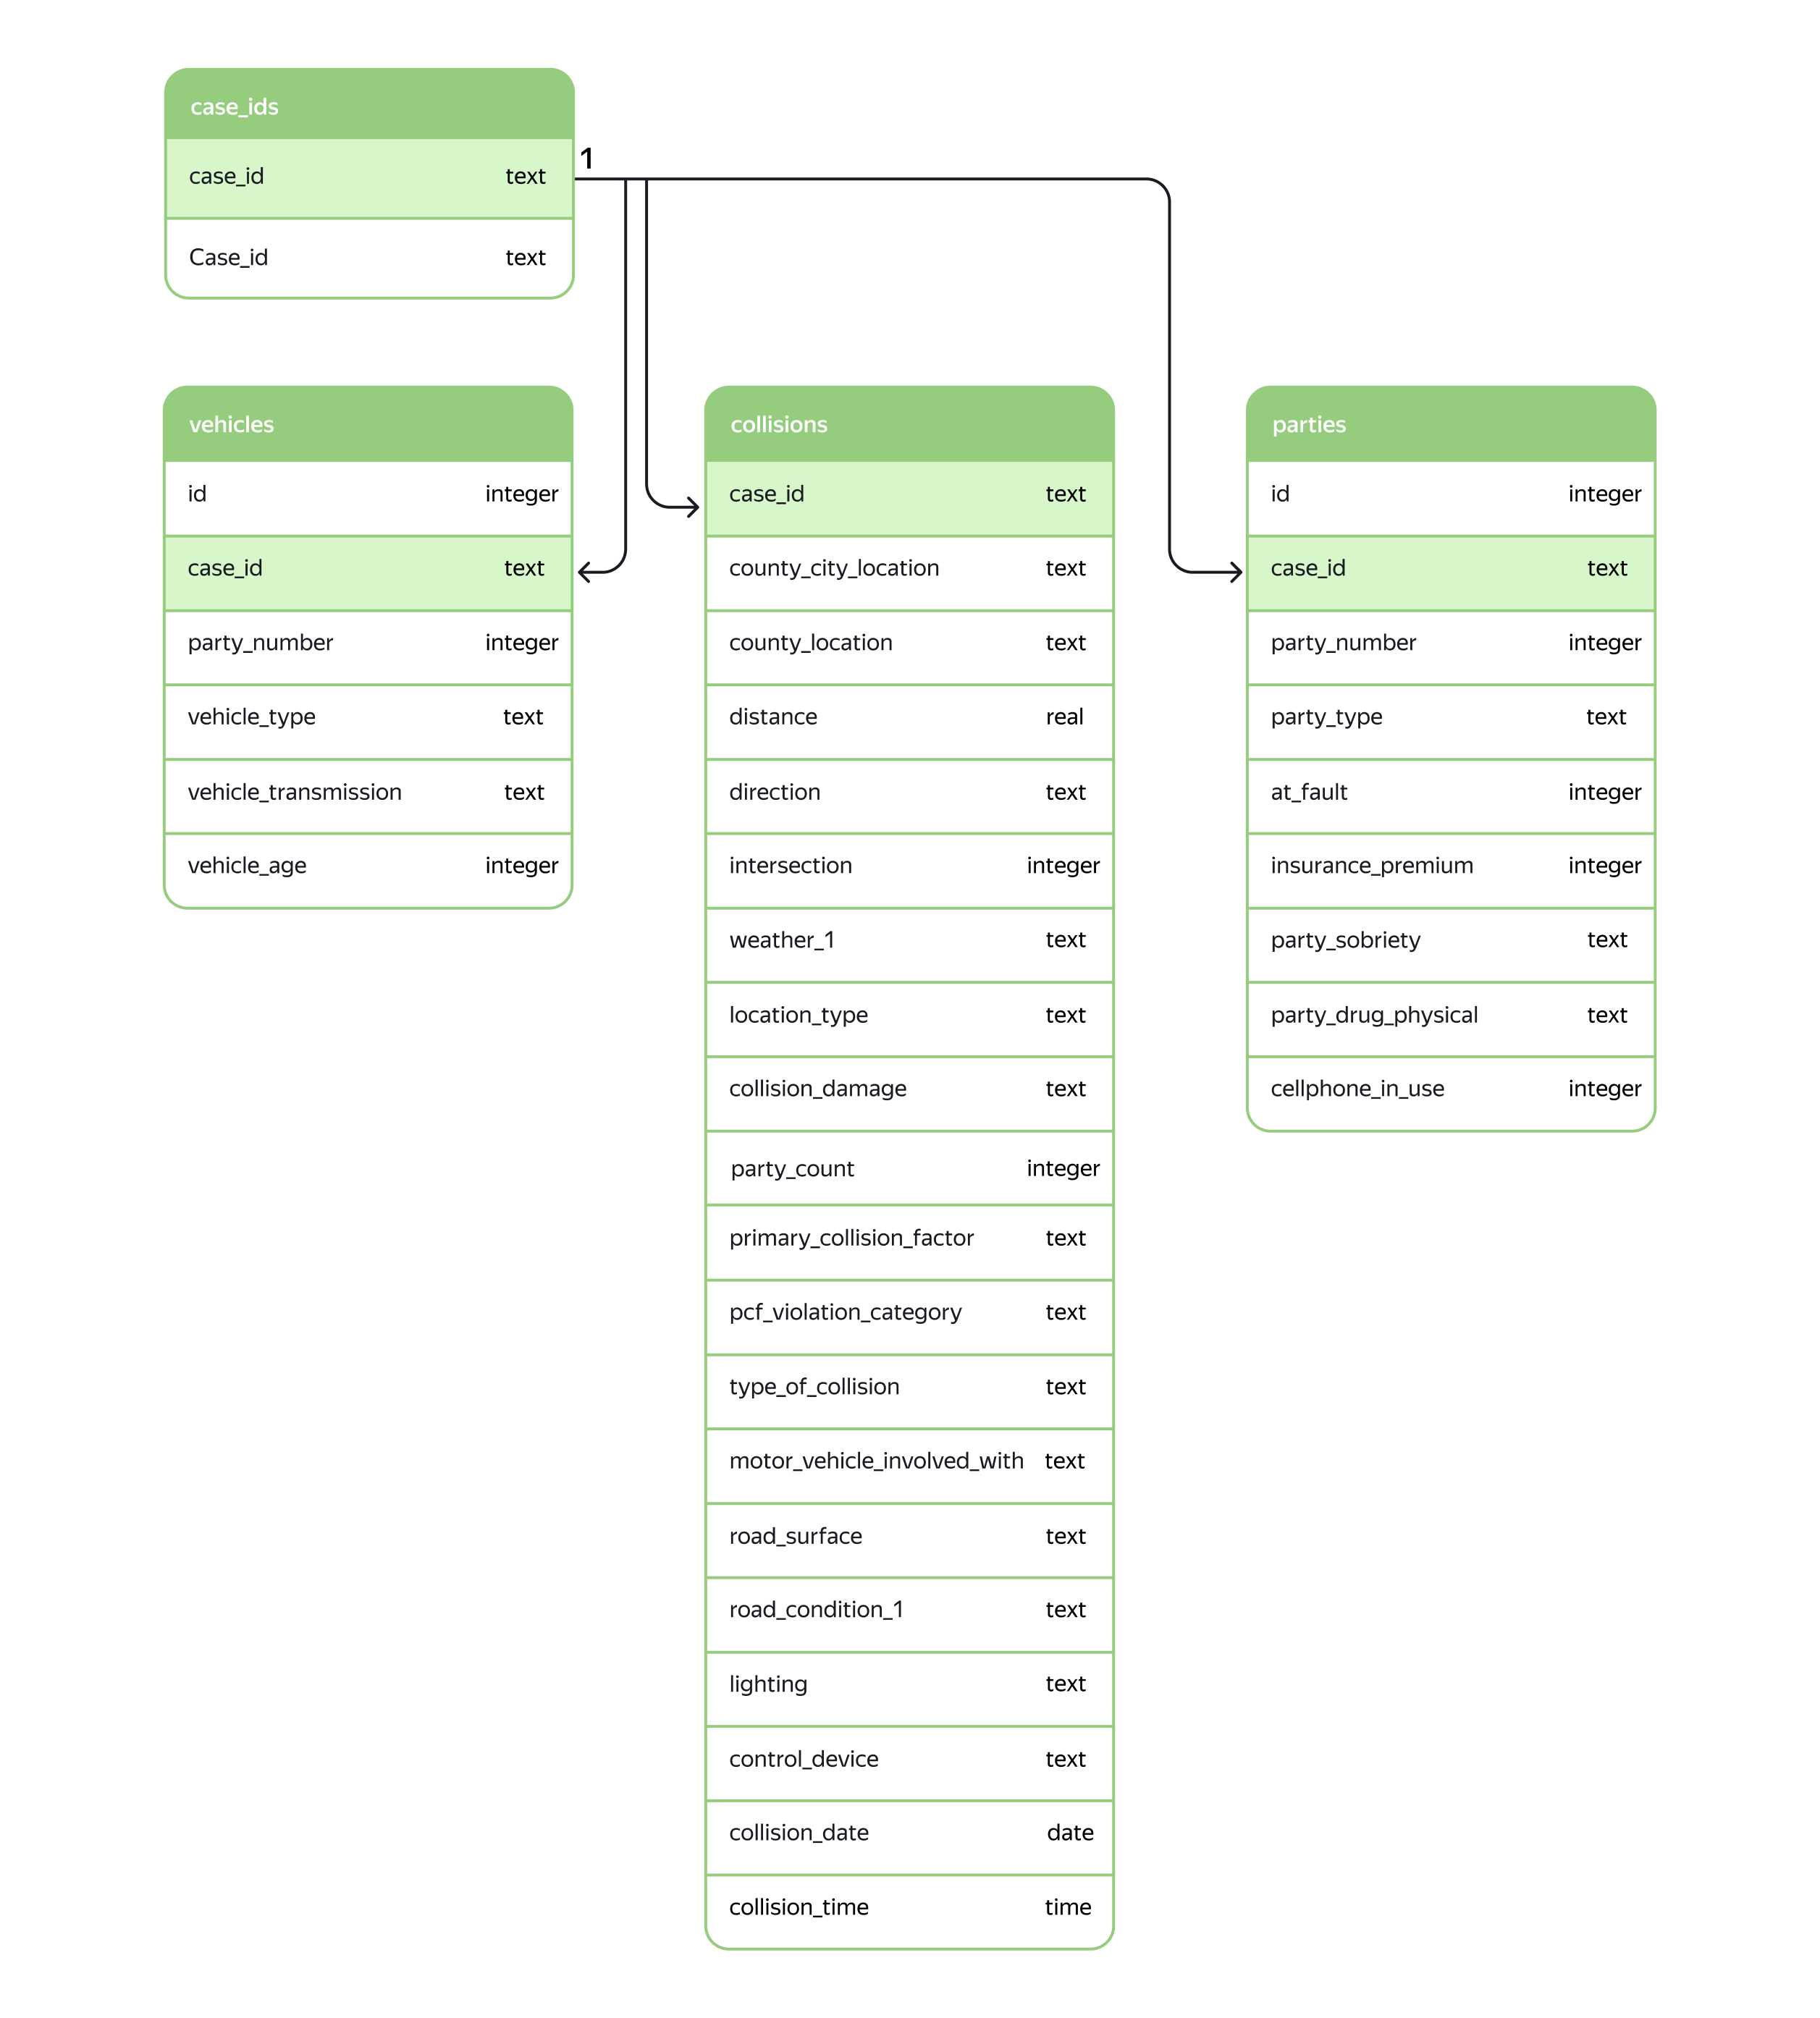

In [10]:
query = '''
SELECT * FROM INFORMATION_SCHEMA.TABLES
'''

sample_df = pd.read_sql_query(query, con=engine)

sample_df

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,data-science-vehicle-db,pg_catalog,pg_type,BASE TABLE,None,None,None,None,None,YES,NO,None
1,data-science-vehicle-db,pg_catalog,pg_foreign_table,BASE TABLE,None,None,None,None,None,YES,NO,None
2,data-science-vehicle-db,pg_catalog,pg_roles,VIEW,None,None,None,None,None,NO,NO,None
3,data-science-vehicle-db,pg_catalog,pg_settings,VIEW,None,None,None,None,None,NO,NO,None
4,data-science-vehicle-db,pg_catalog,pg_amop,BASE TABLE,None,None,None,None,None,YES,NO,None
...,...,...,...,...,...,...,...,...,...,...,...,...
183,data-science-vehicle-db,pg_catalog,pg_inherits,BASE TABLE,None,None,None,None,None,YES,NO,None
184,data-science-vehicle-db,public,collisions,BASE TABLE,None,None,None,None,None,YES,NO,None
185,data-science-vehicle-db,public,case_ids,BASE TABLE,None,None,None,None,None,YES,NO,None
186,data-science-vehicle-db,public,parties,BASE TABLE,None,None,None,None,None,YES,NO,None


In [11]:
query = '''
SELECT *
FROM INFORMATION_SCHEMA.TABLES
WHERE table_name = 'collisions' OR
    table_name = 'parties' OR
    table_name = 'vehicles'
'''

sample_df = pd.read_sql_query(query, con=engine)

sample_df

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,data-science-vehicle-db,public,parties,BASE TABLE,None,None,None,None,None,YES,NO,None
1,data-science-vehicle-db,public,collisions,BASE TABLE,None,None,None,None,None,YES,NO,None
2,data-science-vehicle-db,public,vehicles,BASE TABLE,None,None,None,None,None,YES,NO,None


### Информация о происшествиях - `collisions`

Имеет уникальный `case_id`. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.

In [12]:
query = '''
SELECT *
FROM collisions
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine)

sample_df

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


Таблица `collisions` содержит детальную информацию о ДТП. Признак `case_id` является одновременно и основным ключом и внешним.

### Участники ДТП - `parties`

Имеет неуникальный `case_id`, который сопоставляется с соответствующим ДТП в таблице `collisions`. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением `case_id`. Если нужен уникальный идентификатор, это `case_id` вместе с `party_number`.

In [13]:
query = '''
SELECT *
FROM parties
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine)

sample_df

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


Таблица `parties` содержит детальную информацию об участниках ДТП. Внешний ключ - `case_id` 

### Данные по автомобилям - `vehicles`

Имеет неуникальные `case_id` и неуникальные `party_number`, которые сопоставляются с таблицей `collisions` и таблицей `parties`. Если нужен уникальный идентификатор, это `case_id` вместе с `party_number`.

In [14]:
query = '''
SELECT *
FROM vehicles
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine)

sample_df

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


Таблица `vehicles` содержит детальную информацию об автомобилях, участвовавших в ДТП. Внешний ключ - `case_id` 

### Вывод 

1. Все таблицы имеют наборы данных.
2. Количество таблиц соответствует условию задачи.
3. Имеется общий ключ для связи таблиц.

##  Статистический анализ факторов ДТП

### Задача 1 

Выясните, в какие месяцы происходит наибольшее количество аварий. Проанализируйте весь период наблюдений (таблица collisions).
* Создайте sql-запрос;
* Постройте график;
* Сделайте вывод.

In [15]:
query = '''
WITH first_query AS
    (SELECT EXTRACT(month FROM collision_date) AS month_date
    FROM collisions)

SELECT month_date,
    count(month_date) 
FROM first_query
GROUP BY month_date
'''

sample_df = pd.read_sql_query(query, con=engine)

sample_df

,month_date,count
0,1.0,132044
1,2.0,128858
2,3.0,139581
3,4.0,130180
4,5.0,130316
5,6.0,102594
6,7.0,102227
7,8.0,104089
8,9.0,105159
9,10.0,112237


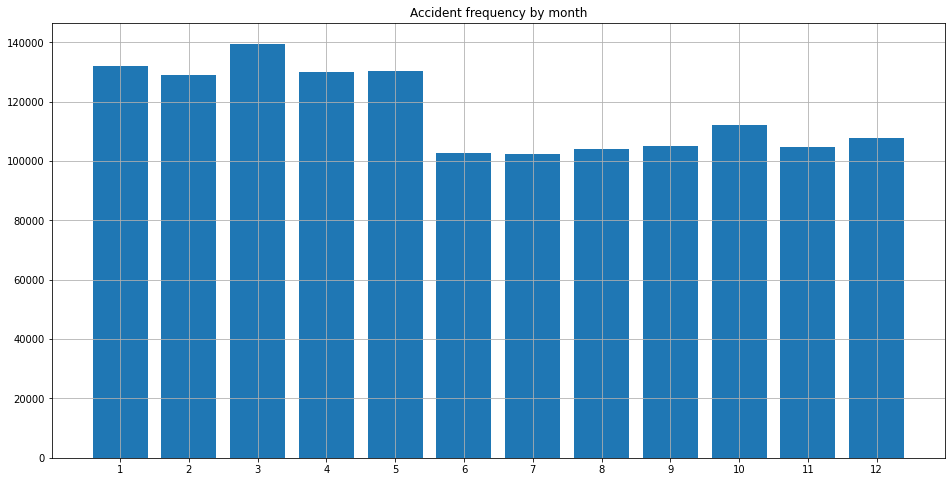

In [16]:
# построим столбчатую диаграмму для визуализации частоты ДТП по месяцам
y = sample_df['count'].values
x = sample_df['month_date'].values


plt.figure(figsize=(16,8))
plt.title('Accident frequency by month')
plt.grid(visible=True)
plt.xticks(x)
plt.bar(x, y)
plt.show()

#### Вывод 

С января по май происходит примерно на 30% больше ДТП.

### Задача 2 

Скоро состоится первое совещание вашей рабочей группы. Чтобы обсуждение было конструктивным, каждый сотрудник должен понимать данные. Для этого вы должны создать подходящие аналитические задачи и поручить их решение коллегам. Примеры задач: 

* Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties);
* Найдите самые частые причины ДТП (таблица parties).


1. Создайте не менее шести задач для коллег. Опирайтесь на примеры и таблицы. 
2. Пропишите порядок решения для двух задач из списка. Реализуйте его. Обязательное условие — решение этих задач должно включать связь не менее 2-х таблиц. Пример прописанного порядка:

* Создайте sql-запрос;
* Постройте график;
* Сделайте вывод.

#### Аналитические задачи

1. Провести анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties).
2. Провести анализ серьезности происшествий в зависимости от трезвости водителя ТС, который при этом является виновником ДТП.
3. Найти самые частые причины ДТП (таблица parties).
4. Провести анализ серьезности ДТП и освещенности в момент ДТП.
5. Проанализировать связь серьезности ДТП и состояния дорожного покрытия (`road_surface`) в момент ДТП.
6. Связать тип коробки передач автомобиля виновника ДТП с серьезностью ДТП.

####  Пример решения аналитической задачи № 1

Необходимо провести анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties).

Для решения данной задачи объединим таблицы `collisions` и `parties`. Сгруппируем их по признакам `collision_damage` и `road_condition_1`. Подсчитаем количество вхождений в получившиеся группы.

In [17]:
query = '''
WITH first_query AS
(SELECT
    c.collision_damage,
    c.road_condition_1
FROM collisions AS c
JOIN parties AS p ON c.case_id = p.case_id
WHERE p.party_type = 'car')

SELECT collision_damage, road_condition_1, COUNT(collision_damage) AS counter
FROM first_query
GROUP BY collision_damage, road_condition_1
ORDER by collision_damage, road_condition_1
'''

sample_df = pd.read_sql_query(query, con=engine)

sample_df

,collision_damage,road_condition_1,counter
0,fatal,construction,330
1,fatal,flooded,7
2,fatal,holes,31
3,fatal,loose material,45
4,fatal,normal,15125
5,fatal,obstruction,74
6,fatal,other,77
7,fatal,reduced width,11
8,fatal,None,102
9,middle damage,construction,3410


На основе полученной таблицы, сформируем сводную таблицу и построим тепловую карту.

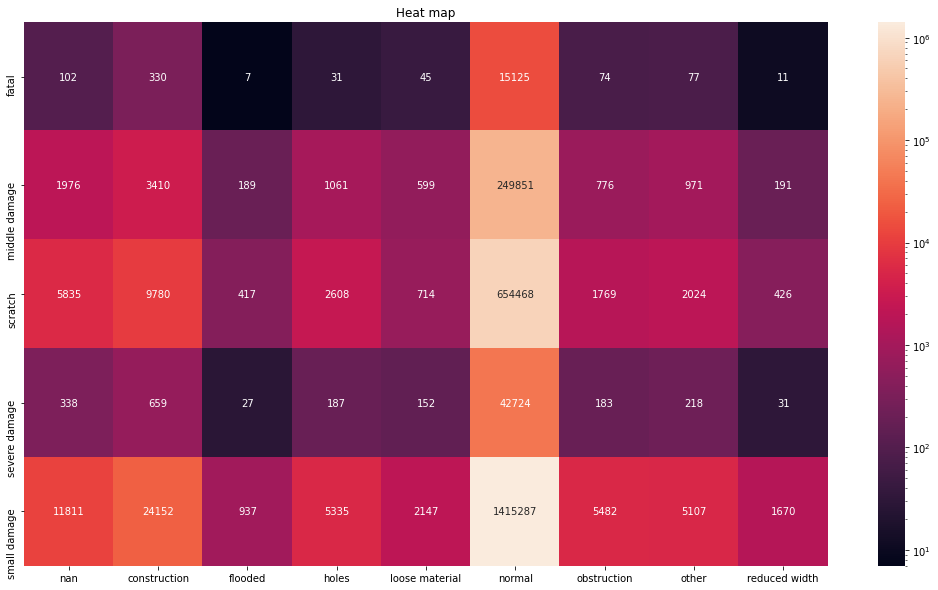

In [18]:
collision_road = sample_df.pivot(index='collision_damage', columns='road_condition_1', values='counter')
collision_road.index = [str(x) for x in collision_road.index]
collision_road.columns = [str(x) for x in collision_road.columns]

plt.figure(figsize=(18, 10)) 
sns.heatmap(collision_road, 
            annot=True, 
            fmt='',
            norm=LogNorm()) 
plt.title('Heat map')
plt.show()

##### Вывод

Описание признаков (могут быть некоторые некоторые несовпадения в названиях категорий)

COLLISION_DAMAGE: Серьёзность происшествия
* 1 — FATAL ТС (Не подлежит восстановлению)
* 2 — SEVERE DAMAGE (Серьёзный ремонт, большая часть под замену/Серьёзное повреждение капитального строения)
* 3 — MIDDLE DAMAGE (Средний ремонт, машина в целом на ходу/Строение в целом устояло)
* 4 — SMALL DAMAGE (Отдельный элемент кузова под замену/покраску)
* 0 — SCRATCH (Царапина)

ROAD_CONDITION_1: Дорожное состояние	
* A — Holes, Deep Ruts (Ямы, глубокая колея)
* B — Loose Material on Roadway (Сыпучий материал на проезжей части)
* C — Obstruction on Roadway (Препятствие на проезжей части)
* D — Construction or Repair Zone (Зона строительства или ремонта)
* E — Reduced Roadway Width (Уменьшенная ширина проезжей части)
* F — Flooded (Затоплено)
* G — Other (Другое)
* H — No Unusual Condition (Нет ничего необычного)
* \- — Not Stated (Не указано)

На основе полученной тепловой карты можно сделать следующие выводы:
* Больше всего происшествий произошло на дорогах без каких-либо аномалий.
* При любом состоянии дороги преобладает категория повреждений Small damage.
* На втором месте по типу повреждений вне зависимости от состояния дороги - Scratch. 
* На затопленных дорогах и дорогах с узкой проезжей частью значительно меньше случаев ДТП, которые привели к серьезным или фатальным повреждениям автомобиля (Severe damage и Fatal категории)

####  Пример решения аналитической задачи № 2

Провести анализ серьезности происшествий в зависимости от трезвости водителя ТС, который при этом является виновником ДТП.

Для решения данной задачи объединим таблицы `collisions` и `parties`. Сгруппируем их по признакам `collision_damage` и `party_sobriety`. Подсчитаем количество вхождений в получившиеся группы.

In [19]:
query = '''
WITH first_query AS
(SELECT
    c.collision_damage,
    p.party_sobriety
FROM collisions AS c
JOIN parties AS p ON c.case_id = p.case_id
WHERE p.at_fault = 1 AND
    p.party_type = 'car')

SELECT collision_damage, party_sobriety, COUNT(collision_damage) AS counter
FROM first_query
GROUP BY collision_damage, party_sobriety
ORDER by collision_damage, party_sobriety
'''

sample_df = pd.read_sql_query(query, con=engine)

sample_df

,collision_damage,party_sobriety,counter
0,fatal,"had been drinking, impairment unknown",236
1,fatal,"had been drinking, not under influence",164
2,fatal,"had been drinking, under influence",2556
3,fatal,had not been drinking,4292
4,fatal,impairment unknown,813
5,fatal,not applicable,7
6,fatal,None,262
7,middle damage,"had been drinking, impairment unknown",1218
8,middle damage,"had been drinking, not under influence",1852
9,middle damage,"had been drinking, under influence",19897


На основе полученной таблицы, сформируем сводную таблицу и построим тепловую карту.

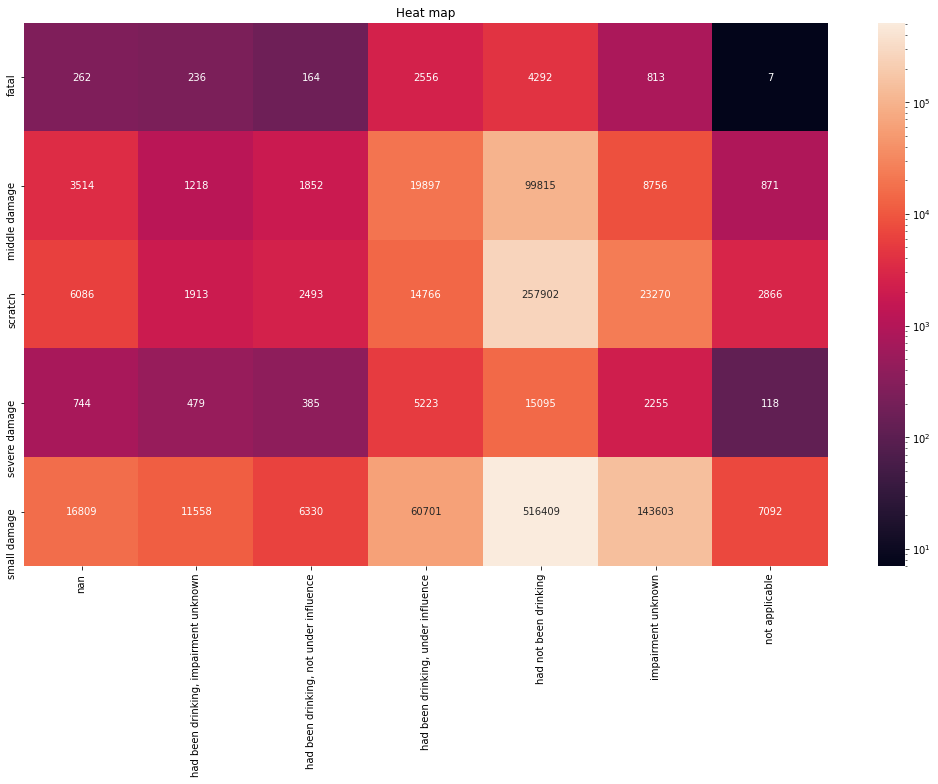

In [20]:
collision_sobriety = sample_df.pivot(index='collision_damage', columns='party_sobriety', values='counter')
collision_sobriety.index = [str(x) for x in collision_sobriety.index]
collision_sobriety.columns = [str(x) for x in collision_sobriety.columns]

plt.figure(figsize=(18, 10)) 
sns.heatmap(collision_sobriety, 
            annot=True, 
            fmt='',
            norm=LogNorm()) 
plt.title('Heat map')
plt.show()

##### Вывод

Описание признаков (могут быть некоторые некоторые несовпадения в названиях категорий)

COLLISION_DAMAGE: Серьёзность происшествия
* 1 — FATAL ТС (Не подлежит восстановлению)
* 2 — SEVERE DAMAGE (Серьёзный ремонт, большая часть под замену/Серьёзное повреждение капитального строения)
* 3 — MIDDLE DAMAGE (Средний ремонт, машина в целом на ходу/Строение в целом устояло)
* 4 — SMALL DAMAGE (Отдельный элемент кузова под замену/покраску)
* 0 — SCRATCH (Царапина)

PARTY_SOBRIETY: Трезвость участника	
* A — Had Not Been Drinking (Не пил)
* B — Had Been Drinking, Under Influence (Был пьян, под влиянием)
* C — Had Been Drinking, Not Under Influence (Был пьян, не под влиянием)
* D — Had Been Drinking, Impairment Unknown (Был пьян, ухудшение неизвестно)
* G — Impairment Unknown (Неизвестно ухудшение)
* H — Not Applicable (Не оценивался)
* \- — Not Stated (Не указано)

На основе полученной тепловой карты можно сделать следующие выводы:
* Больше всего происшествий произошло по вине трезвых водителей.
* В не зависимости от состояния опьянения, чаще всего серьезность происшествия была на уровне Scratch. 
* По вине пьяных водителей ДТП относительно чаще приводили к повреждениям вида Middle damage и Fatal, чем по вине трезвых водителей.

## Создание модели для оценки водительского риска

### Подготовка данных 

Подготовим набор данных на основе первичного предположения заказчика:
* Выберем тип виновника — только машина (car). 
* Возьмём случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
* Для моделирования возьмём данные только за 2012 год.

In [21]:
query = '''
SELECT *
FROM collisions AS c
JOIN parties AS p ON c.case_id = p.case_id
JOIN vehicles AS v ON p.case_id = v.case_id AND p.party_number = v.party_number
WHERE p.party_type = 'car' AND
    c.collision_damage != 'scratch' AND
    EXTRACT(year FROM collision_date) = 2012
'''

df = pd.read_sql_query(query, con=engine)

df.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,...,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,5600850,5604,ventura,150.0,north,0.0,clear,highway,small damage,2,...,NaN,impairment unknown,G,0.0,1465119,5600850,2,sedan,auto,NaN
1,5600893,2908,nevada,190.0,east,0.0,clear,None,small damage,1,...,38.0,"had been drinking, under influence",None,0.0,1465137,5600893,1,sedan,auto,6.0
2,5603123,1600,kings,2640.0,east,0.0,cloudy,highway,small damage,2,...,20.0,had not been drinking,None,0.0,1466829,5603123,1,sedan,auto,11.0
3,5455644,4806,solano,350.0,south,0.0,cloudy,ramp,small damage,3,...,22.0,had not been drinking,None,0.0,1327255,5455644,3,sedan,manual,3.0
4,5455680,3001,orange,0.0,None,1.0,clear,None,small damage,3,...,59.0,had not been drinking,None,0.0,1327290,5455680,3,sedan,manual,NaN


In [22]:
df.shape

(56248, 35)

У нас получился датасет состоящий из 35 признаков и 56248 записей.

### Отбор факторов, необходимых для модели

Проведём первичный отбор факторов, необходимых для модели.

Описание оригинальной задачи:
> Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
>
> Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

В данном случае мы создаём модель, которая по признакам будет предсказывать вероятность ДТП (целевой признак `at_fault`) по данным из какой-то конкретной географической точки.

Отберём факторы, которые помогут решить данную задачу.

In [23]:
# Список всех признаков в датасете
df.columns

Index(['case_id', 'county_city_location', 'county_location', 'distance',
       'direction', 'intersection', 'weather_1', 'location_type',
       'collision_damage', 'party_count', 'primary_collision_factor',
       'pcf_violation_category', 'type_of_collision',
       'motor_vehicle_involved_with', 'road_surface', 'road_condition_1',
       'lighting', 'control_device', 'collision_date', 'collision_time', 'id',
       'case_id', 'party_number', 'party_type', 'at_fault',
       'insurance_premium', 'party_sobriety', 'party_drug_physical',
       'cellphone_in_use', 'id', 'case_id', 'party_number', 'vehicle_type',
       'vehicle_transmission', 'vehicle_age'],
      dtype='object')

In [24]:
# Перечень признаков, которые будем использовать
columns =['distance', # Расстояние до главной дороги в метрах. Количественный признак. Может помочь определить целевой признак
          'intersection', # Является ли место ДТП перекрёстком. Категориальный признак. Может помочь определить целевой признак
          'weather_1', # Погода. Категориальный признак. Оказывает влияние на целевой признак
          'location_type', # Тип дороги. Категориальный признак. Может помочь определить целевой признак
          'road_surface', # Состояние дороги. Категориальный признак. Оказывает влияние на целевой признак
          'road_condition_1', # Дополнительные аномалии на дороге. Категориальный признак. Оказывает влияние на целевой признак
          'lighting', # Освещение. Категориальный признак. Оказывает влияние на целевой признак
          'collision_date', # Дата ДТП. Как показал анализ в начале, есть месяцы с повышенной частотой аварий. Сконвертируем в месяц.
          'collision_time', # Время ДТП. 24-часовой формат. Может оказывать влияние. Сконвертируем потом через синус/косинус в цикличный признак.
          'at_fault', # Является ли виновником ДТП. Категориальный целевой признак
          'party_sobriety', # Трезвость участника ДТП. Точно оказывает влияние
          'party_drug_physical', # Общее состояние участника ДТП. Точно оказывает влияние
          'vehicle_type', # Тип авто. Может оказывать влияние.
          'vehicle_transmission', # Тип коробки передач. Может оказывать влияние.
          'vehicle_age', # Возвраст авто. Может оказывать влияние.
         ] 

df = df[columns]

df.columns

Index(['distance', 'intersection', 'weather_1', 'location_type',
       'road_surface', 'road_condition_1', 'lighting', 'collision_date',
       'collision_time', 'at_fault', 'party_sobriety', 'party_drug_physical',
       'vehicle_type', 'vehicle_transmission', 'vehicle_age'],
      dtype='object')

### Статистическое исследование отобранных факторов

Проведите статистическое исследование отобранных факторов.

    По результату исследовательского анализа внесите корректировки, если они нужны. Сделайте вывод.
    Если необходимо, категоризируйте исходные данные, проведите масштабирование.
    Подготовьте обучающую и тестовую выборки.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              56248 non-null  float64
 1   intersection          56073 non-null  float64
 2   weather_1             56080 non-null  object 
 3   location_type         25932 non-null  object 
 4   road_surface          55900 non-null  object 
 5   road_condition_1      55999 non-null  object 
 6   lighting              56094 non-null  object 
 7   collision_date        56248 non-null  object 
 8   collision_time        56160 non-null  object 
 9   at_fault              56248 non-null  int64  
 10  party_sobriety        55376 non-null  object 
 11  party_drug_physical   2857 non-null   object 
 12  vehicle_type          56248 non-null  object 
 13  vehicle_transmission  55389 non-null  object 
 14  vehicle_age           54554 non-null  float64
dtypes: float64(3), int6

#### Проверка на дубликаты

In [26]:
df.duplicated().sum()

134

In [27]:
# Удалим дубликаты
df = df.drop_duplicates().reset_index(drop=True)

df.duplicated().sum()

0

#### `distance` 

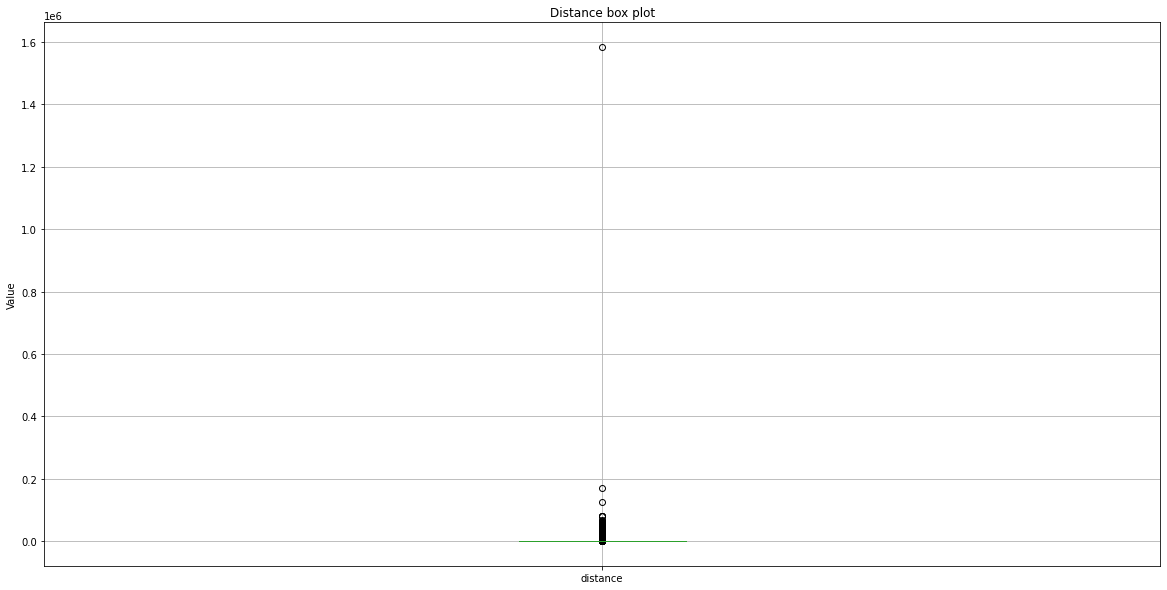

In [28]:
ax = df.boxplot(column='distance', figsize=(20, 10))

ax.set_ylabel('Value')
ax.set_title('Distance box plot')

plt.show()

In [29]:
df['distance'].describe()

count    5.611400e+04
mean     8.594215e+02
std      7.248203e+03
min      0.000000e+00
25%      7.000000e+00
50%      1.340000e+02
75%      5.437500e+02
max      1.584000e+06
Name: distance, dtype: float64

Имеются существенные выбросы, удалим их. Максимальное значение близко к 1600000 метрам, что является явной ошибкой.

In [30]:
df['distance'].quantile(0.95)

3168.0

Уберём выбросы после сплитования.

In [31]:
# Количество пропущенных значений
df['distance'].isna().sum()

0

#### `intersection`

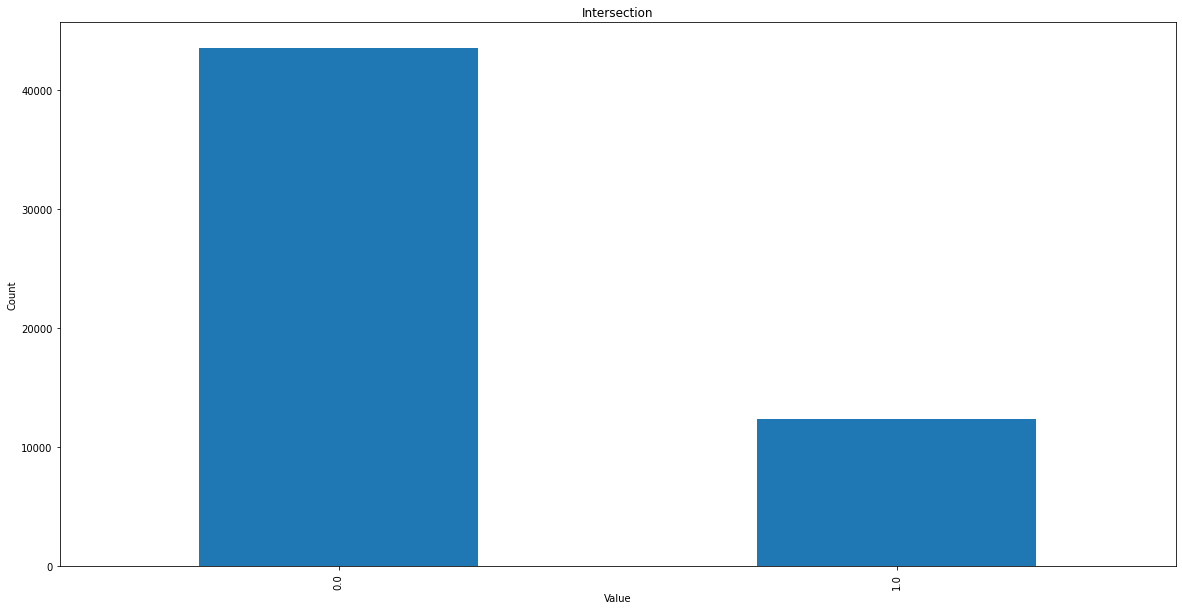

In [32]:
ax = df['intersection'].value_counts().plot.bar(figsize=(20, 10), title='Intersection')

ax.set_ylabel('Count')
ax.set_xlabel('Value')

plt.show()

Есть перекос по данным. Оставим как есть.

#### `weather_1`

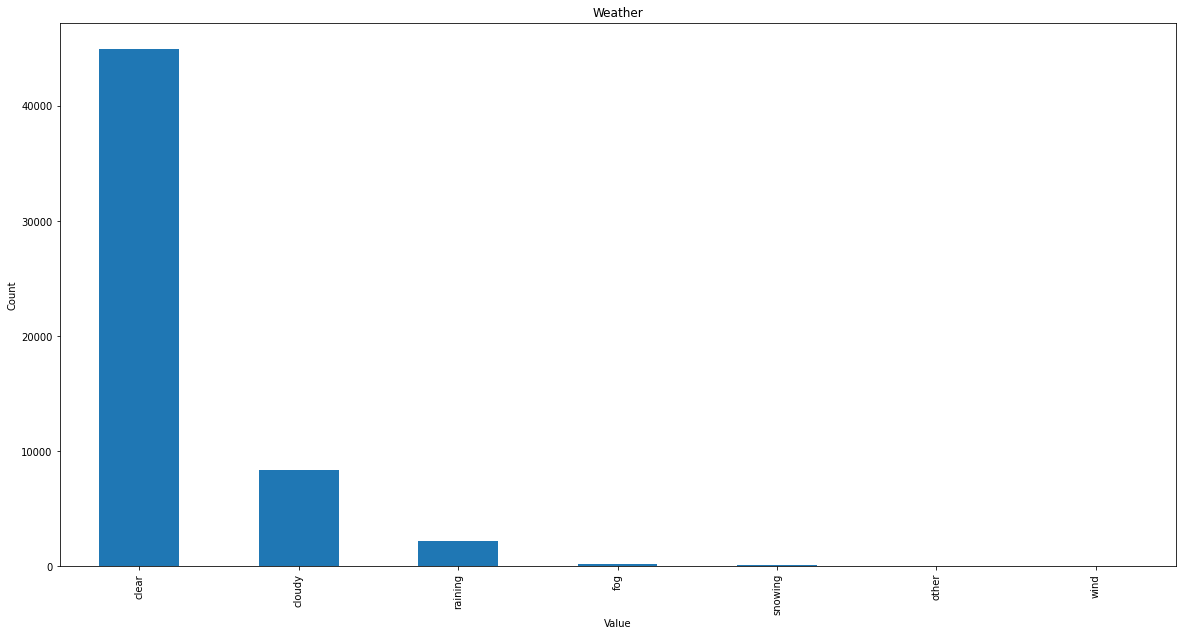

In [33]:
ax = df['weather_1'].value_counts().plot.bar(figsize=(20, 10), title='Weather')

ax.set_ylabel('Count')
ax.set_xlabel('Value')

plt.show()

Имеется значительный перекос в сторону случаев ДТП с ясной погодой.

#### `location_type`

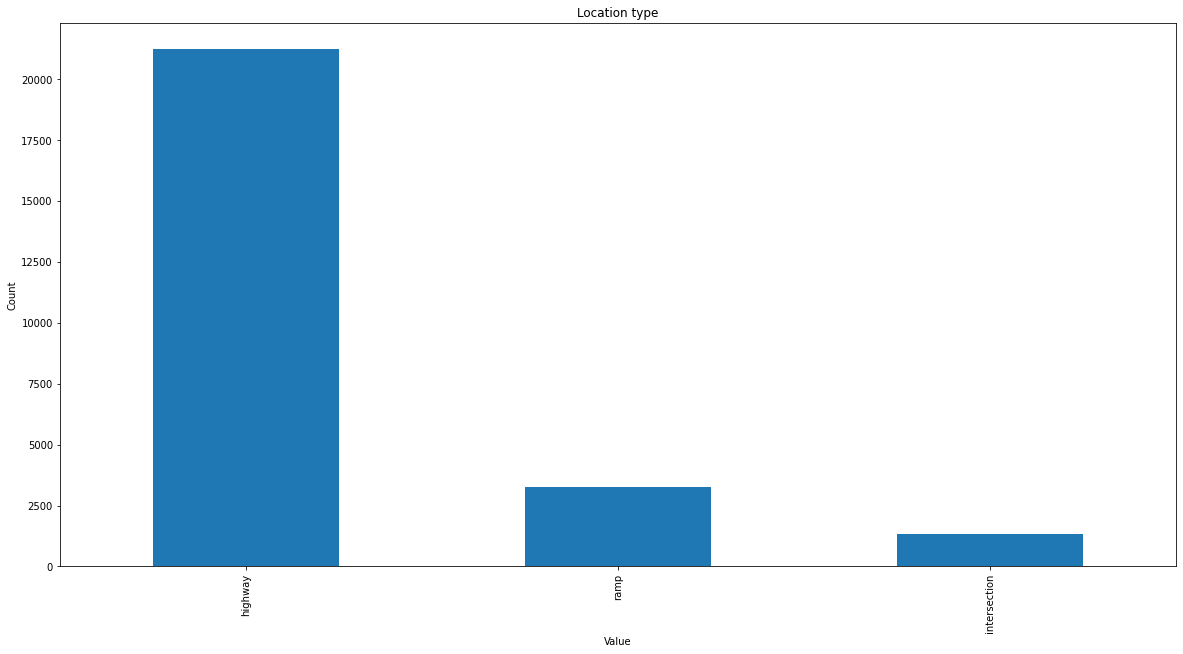

In [34]:
ax = df['location_type'].value_counts().plot.bar(figsize=(20, 10), title='Location type')

ax.set_ylabel('Count')
ax.set_xlabel('Value')

plt.show()

Большинство ДТП происходило на шоссе (`highway`). 

По какой-то причине здесь имеется тип дороги `intersection`. Это кажется дублирует признак `intersection`. Количество записей не совпадает между этими двумя признаками. Оставим как есть.

#### `road_surface`

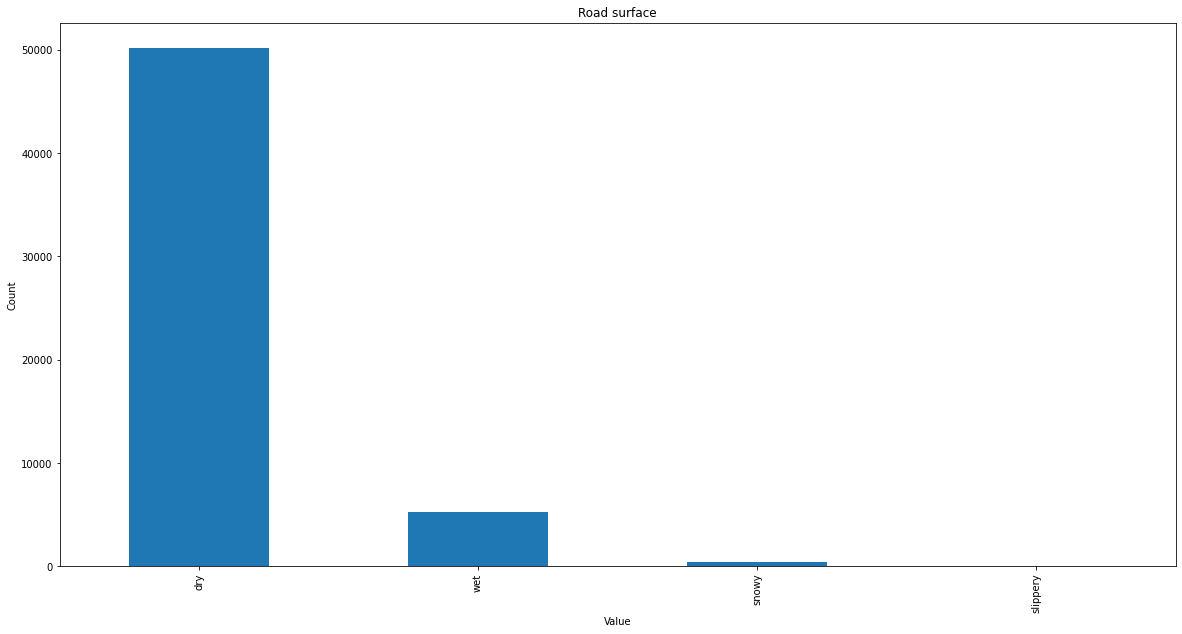

In [35]:
ax = df['road_surface'].value_counts().plot.bar(figsize=(20, 10), title='Road surface')

ax.set_ylabel('Count')
ax.set_xlabel('Value')

plt.show()

#### `road_condition_1`

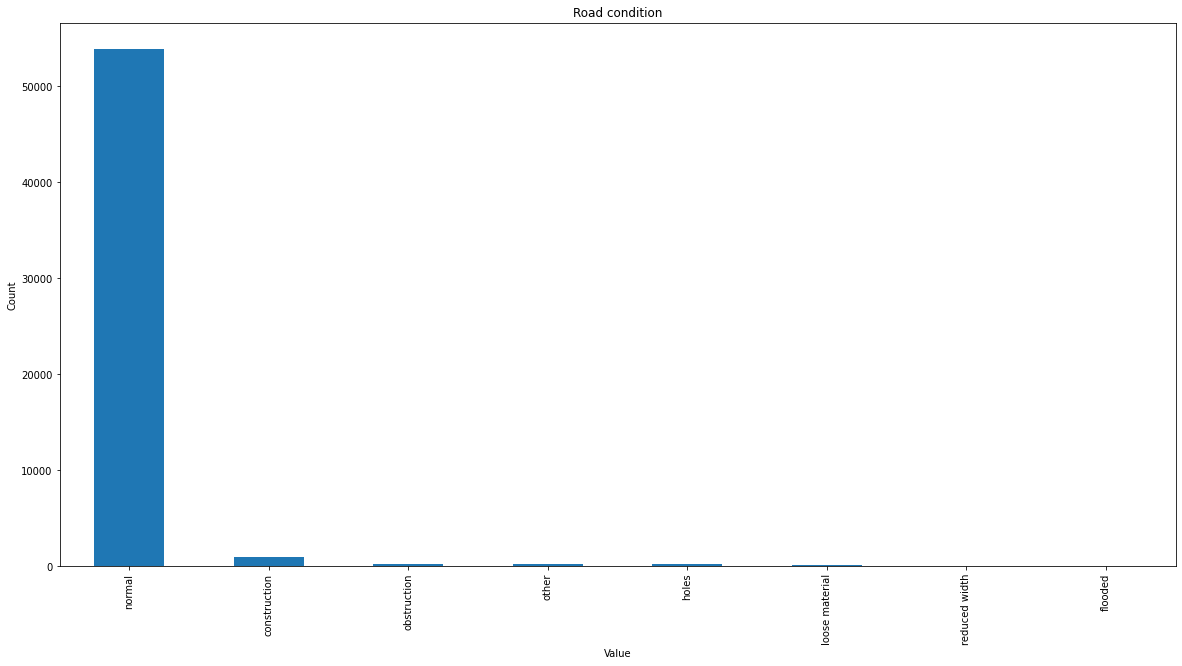

In [36]:
ax = df['road_condition_1'].value_counts().plot.bar(figsize=(20, 10), title='Road condition')

ax.set_ylabel('Count')
ax.set_xlabel('Value')

plt.show()

Большой перекос в сторону ДТП на сухой дороге.

#### `lighting`

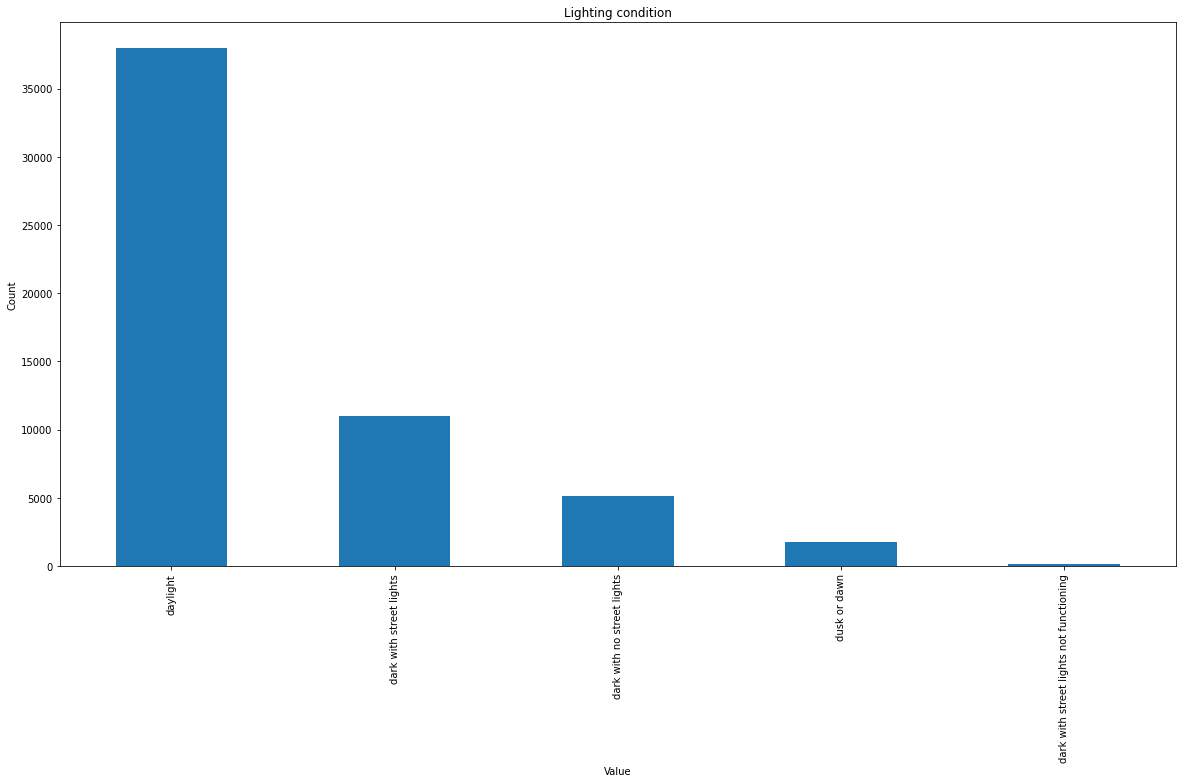

In [37]:
ax = df['lighting'].value_counts().plot.bar(figsize=(20, 10), title='Lighting condition')

ax.set_ylabel('Count')
ax.set_xlabel('Value')

plt.show()

Большая часть ДТП происходила при дневном свете.

#### `collision_date`

Извлечём из данного признака месяц и переведём значения в полярную систему координат, расположив значения на окружности и высчитав синус и косинус для каждого значения. Таким образом мы сможем объяснить модели машинного обучения, что максимальное и минимальное значения близки друг к другу. Например как 23 часа и 0 часов.

In [38]:
df['collision_date']

0        2012-04-19
1        2012-04-21
2        2012-04-13
3        2012-01-02
4        2012-01-01
            ...    
56109    2012-02-29
56110    2012-10-23
56111    2012-09-29
56112    2012-11-05
56113    2012-09-21
Name: collision_date, Length: 56114, dtype: object

In [39]:
df['collision_date'] = pd.to_datetime(df['collision_date'], format='%Y-%m-%d')
df['collision_date']

0       2012-04-19
1       2012-04-21
2       2012-04-13
3       2012-01-02
4       2012-01-01
           ...    
56109   2012-02-29
56110   2012-10-23
56111   2012-09-29
56112   2012-11-05
56113   2012-09-21
Name: collision_date, Length: 56114, dtype: datetime64[ns]

In [40]:
df['collision_date'].dt.month

0         4
1         4
2         4
3         1
4         1
         ..
56109     2
56110    10
56111     9
56112    11
56113     9
Name: collision_date, Length: 56114, dtype: int64

In [41]:
df['collision_month_sin'] = np.sin(df['collision_date'].dt.month*(2.*np.pi/12))
df['collision_month_cos'] = np.cos(df['collision_date'].dt.month*(2.*np.pi/12))

df.head()

,distance,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,collision_date,collision_time,at_fault,party_sobriety,party_drug_physical,vehicle_type,vehicle_transmission,vehicle_age,collision_month_sin,collision_month_cos
0,150.0,0.0,clear,highway,dry,normal,daylight,2012-04-19,12:44:00,0,impairment unknown,G,sedan,auto,NaN,0.866025,-0.500000
1,190.0,0.0,clear,None,dry,normal,dark with no street lights,2012-04-21,00:50:00,1,"had been drinking, under influence",None,sedan,auto,6.0,0.866025,-0.500000
2,2640.0,0.0,cloudy,highway,wet,normal,daylight,2012-04-13,14:34:00,1,had not been drinking,None,sedan,auto,11.0,0.866025,-0.500000
3,350.0,0.0,cloudy,ramp,dry,normal,daylight,2012-01-02,15:32:00,1,had not been drinking,None,sedan,manual,3.0,0.500000,0.866025
4,0.0,1.0,clear,None,dry,normal,dark with street lights,2012-01-01,22:06:00,0,had not been drinking,None,sedan,manual,NaN,0.500000,0.866025


In [42]:
df = df.drop('collision_date', axis=1)
df.columns

Index(['distance', 'intersection', 'weather_1', 'location_type',
       'road_surface', 'road_condition_1', 'lighting', 'collision_time',
       'at_fault', 'party_sobriety', 'party_drug_physical', 'vehicle_type',
       'vehicle_transmission', 'vehicle_age', 'collision_month_sin',
       'collision_month_cos'],
      dtype='object')

#### `collision_time`

С данным признаком повторим тоже самое, что и с `collision_date`. Сконвертируем его в часы и переведём в полярную систему координат.

In [43]:
df['collision_time']

0        12:44:00
1        00:50:00
2        14:34:00
3        15:32:00
4        22:06:00
           ...   
56109    20:46:00
56110    21:39:00
56111    13:28:00
56112    03:30:00
56113    07:35:00
Name: collision_time, Length: 56114, dtype: object

In [44]:
df['collision_time'] = pd.to_datetime(df['collision_time'], format='%H:%M:%S')
df['collision_time']

0       1900-01-01 12:44:00
1       1900-01-01 00:50:00
2       1900-01-01 14:34:00
3       1900-01-01 15:32:00
4       1900-01-01 22:06:00
                ...        
56109   1900-01-01 20:46:00
56110   1900-01-01 21:39:00
56111   1900-01-01 13:28:00
56112   1900-01-01 03:30:00
56113   1900-01-01 07:35:00
Name: collision_time, Length: 56114, dtype: datetime64[ns]

In [45]:
df['collision_time'].dt.hour

0        12.0
1         0.0
2        14.0
3        15.0
4        22.0
         ... 
56109    20.0
56110    21.0
56111    13.0
56112     3.0
56113     7.0
Name: collision_time, Length: 56114, dtype: float64

In [46]:
df['collision_hour_sin'] = np.sin(df['collision_time'].dt.hour*(2.*np.pi/24))
df['collision_hour_cos'] = np.cos(df['collision_time'].dt.hour*(2.*np.pi/24))

df.head()

,distance,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,collision_time,at_fault,party_sobriety,party_drug_physical,vehicle_type,vehicle_transmission,vehicle_age,collision_month_sin,collision_month_cos,collision_hour_sin,collision_hour_cos
0,150.0,0.0,clear,highway,dry,normal,daylight,1900-01-01 12:44:00,0,impairment unknown,G,sedan,auto,NaN,0.866025,-0.500000,1.224647e-16,-1.000000
1,190.0,0.0,clear,None,dry,normal,dark with no street lights,1900-01-01 00:50:00,1,"had been drinking, under influence",None,sedan,auto,6.0,0.866025,-0.500000,0.000000e+00,1.000000
2,2640.0,0.0,cloudy,highway,wet,normal,daylight,1900-01-01 14:34:00,1,had not been drinking,None,sedan,auto,11.0,0.866025,-0.500000,-5.000000e-01,-0.866025
3,350.0,0.0,cloudy,ramp,dry,normal,daylight,1900-01-01 15:32:00,1,had not been drinking,None,sedan,manual,3.0,0.500000,0.866025,-7.071068e-01,-0.707107
4,0.0,1.0,clear,None,dry,normal,dark with street lights,1900-01-01 22:06:00,0,had not been drinking,None,sedan,manual,NaN,0.500000,0.866025,-5.000000e-01,0.866025


In [47]:
df = df.drop('collision_time', axis=1)
df.columns

Index(['distance', 'intersection', 'weather_1', 'location_type',
       'road_surface', 'road_condition_1', 'lighting', 'at_fault',
       'party_sobriety', 'party_drug_physical', 'vehicle_type',
       'vehicle_transmission', 'vehicle_age', 'collision_month_sin',
       'collision_month_cos', 'collision_hour_sin', 'collision_hour_cos'],
      dtype='object')

#### `at_fault`

Целевой признак

In [48]:
# Проверим на пропуски
df['at_fault'].isna().sum() 

0

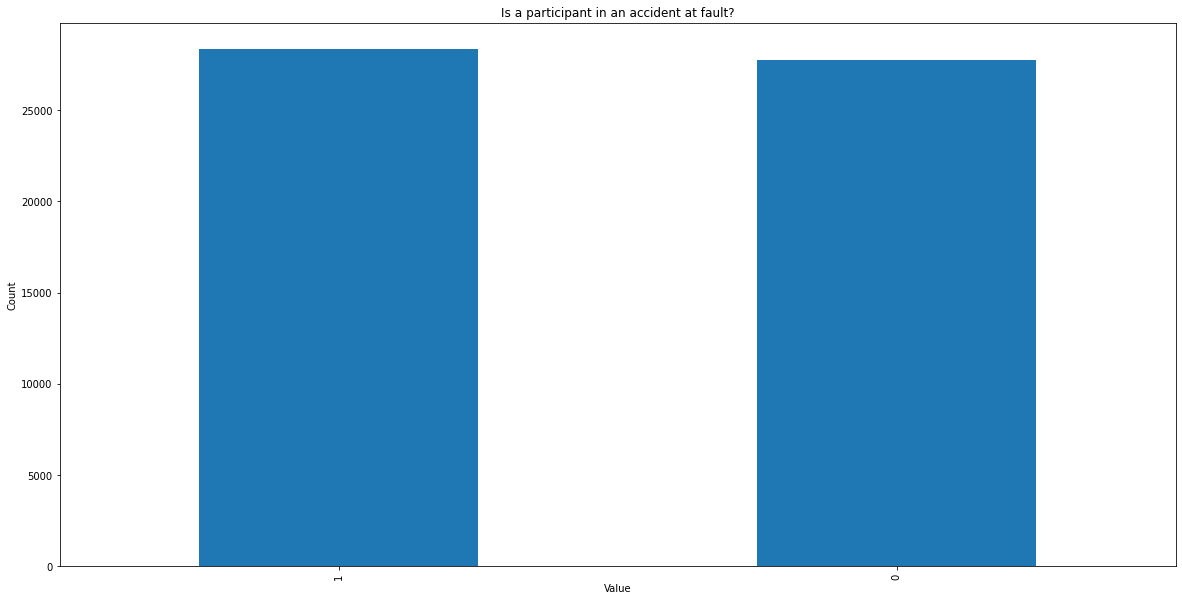

In [49]:
ax = df['at_fault'].value_counts().plot.bar(figsize=(20, 10), title='Is a participant in an accident at fault?')

ax.set_ylabel('Count')
ax.set_xlabel('Value')

plt.show()

Почти равное распределение выборки по целевому признаку.

#### `party_sobriety`

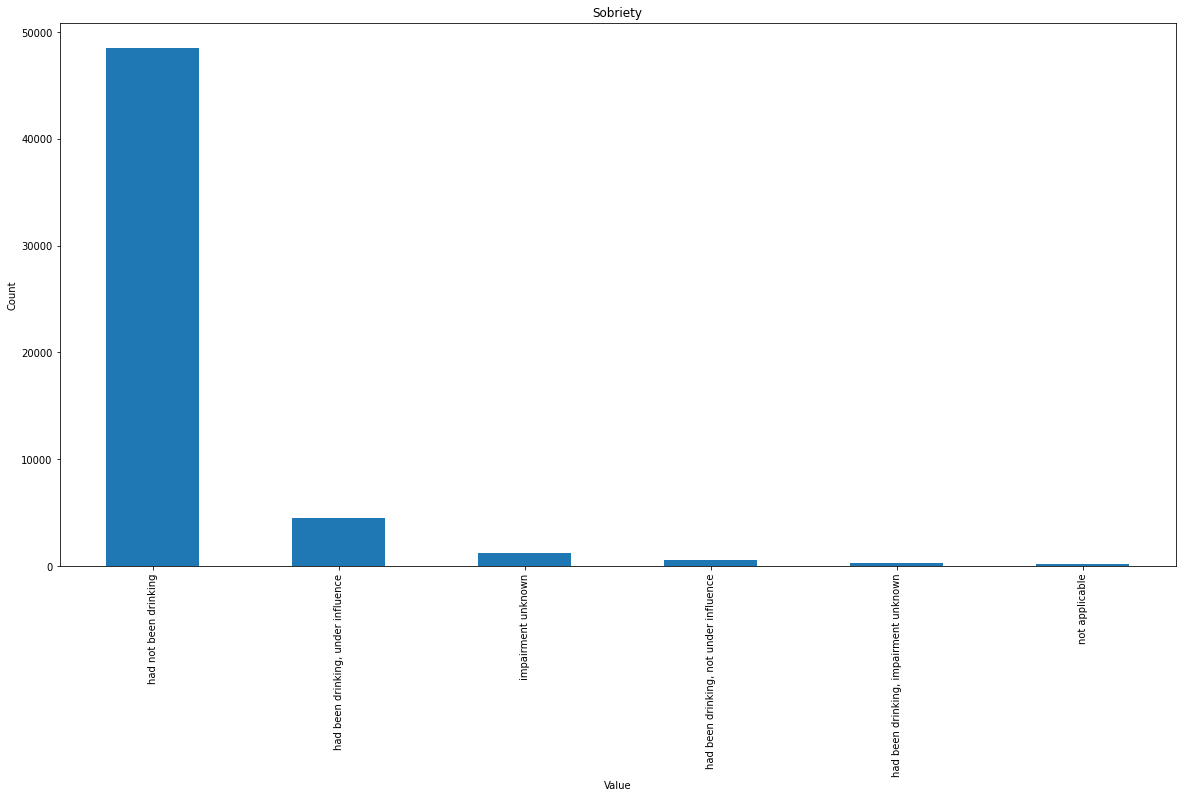

In [50]:
ax = df['party_sobriety'].value_counts().plot.bar(figsize=(20, 10), title='Sobriety')

ax.set_ylabel('Count')
ax.set_xlabel('Value')

plt.show()

В большинстве случаев участники ДТП не были под влиянием алкоголя

#### `party_drug_physical`

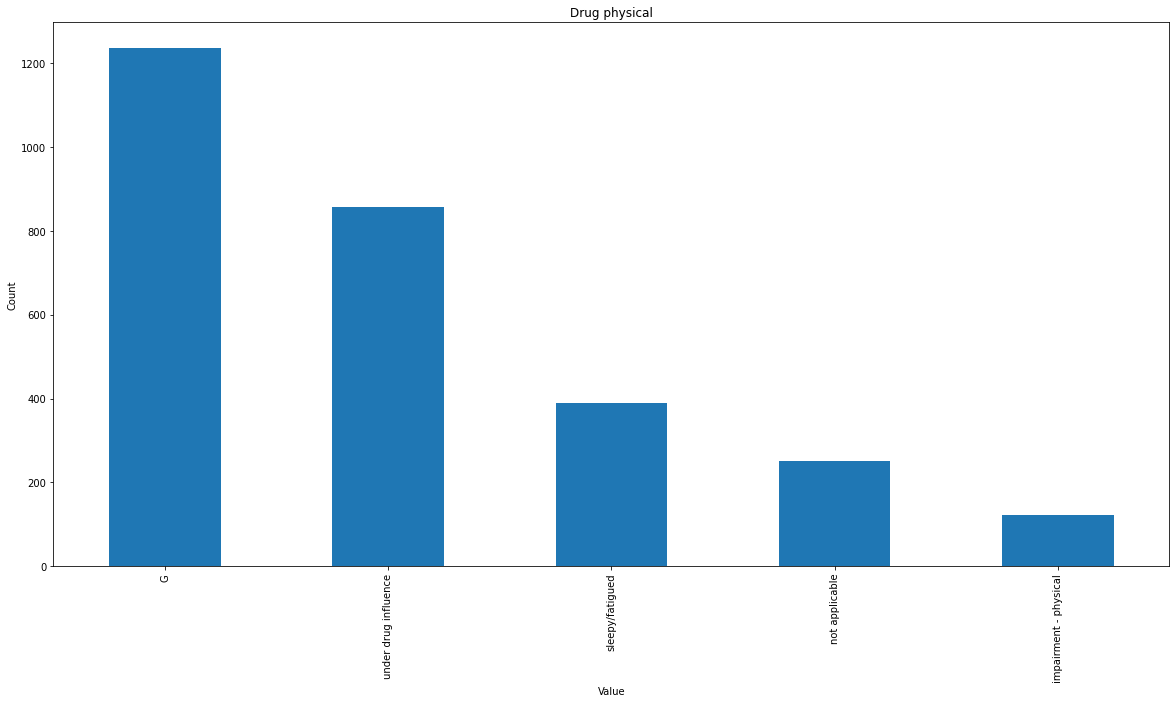

In [51]:
ax = df['party_drug_physical'].value_counts().plot.bar(figsize=(20, 10), title='Drug physical')

ax.set_ylabel('Count')
ax.set_xlabel('Value')

plt.show()

In [52]:
df['party_drug_physical'].value_counts()

G                        1236
under drug influence      857
sleepy/fatigued           390
not applicable            250
impairment - physical     122
Name: party_drug_physical, dtype: int64

Общее количество записей в этом признаке очень небольшое, относительно датасета. Удалим признак.

In [53]:
df = df.drop('party_drug_physical', axis=1)
df.columns

Index(['distance', 'intersection', 'weather_1', 'location_type',
       'road_surface', 'road_condition_1', 'lighting', 'at_fault',
       'party_sobriety', 'vehicle_type', 'vehicle_transmission', 'vehicle_age',
       'collision_month_sin', 'collision_month_cos', 'collision_hour_sin',
       'collision_hour_cos'],
      dtype='object')

#### `vehicle_type`

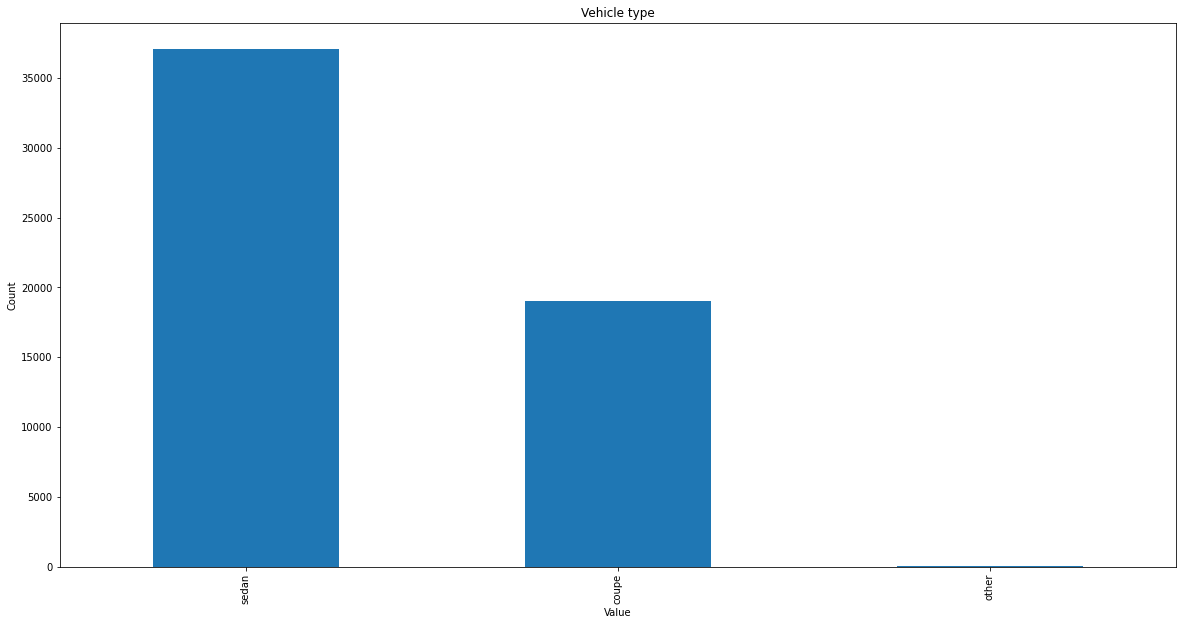

In [54]:
ax = df['vehicle_type'].value_counts().plot.bar(figsize=(20, 10), title='Vehicle type')

ax.set_ylabel('Count')
ax.set_xlabel('Value')

plt.show()

Большинство ДТП произошло на седанах. Вероятно потому что это наиболее распространенный тип кузова. На втором месте купе. Признак в целом кажется не особо полезным. Удалим его.

In [55]:
df = df.drop('vehicle_type', axis=1)
df.columns

Index(['distance', 'intersection', 'weather_1', 'location_type',
       'road_surface', 'road_condition_1', 'lighting', 'at_fault',
       'party_sobriety', 'vehicle_transmission', 'vehicle_age',
       'collision_month_sin', 'collision_month_cos', 'collision_hour_sin',
       'collision_hour_cos'],
      dtype='object')

#### `vehicle_transmission`

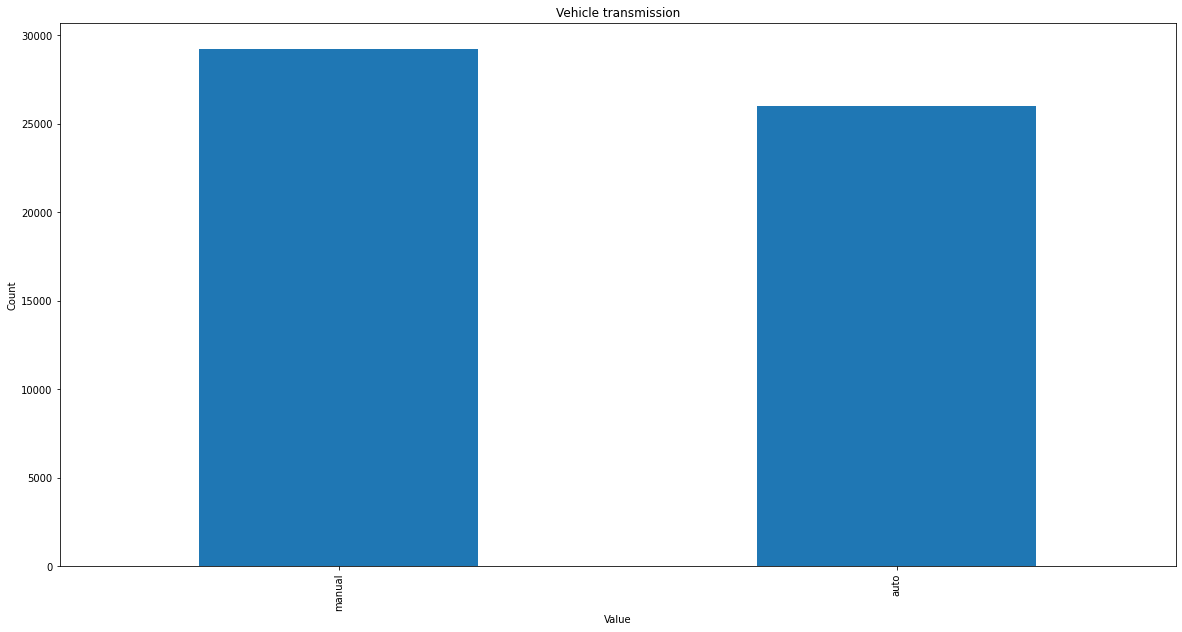

In [56]:
ax = df['vehicle_transmission'].value_counts().plot.bar(figsize=(20, 10), title='Vehicle transmission')

ax.set_ylabel('Count')
ax.set_xlabel('Value')

plt.show()

Почти равное распределение ДТП по типу коробки передач.

#### `vehicle_age`

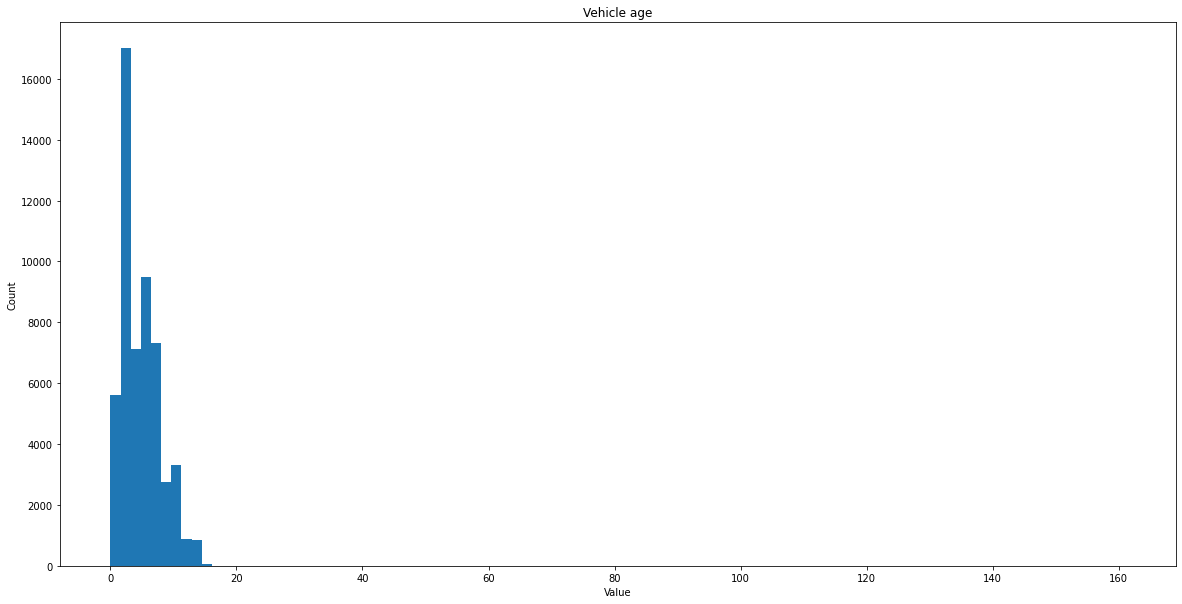

In [57]:
ax = df['vehicle_age'].plot.hist(bins=100, figsize=(20, 10), title='Vehicle age')

ax.set_ylabel('Count')
ax.set_xlabel('Value')

plt.show()

In [58]:
df['vehicle_age'].describe()

count    54426.000000
mean         4.857899
std          3.235724
min          0.000000
25%          3.000000
50%          4.000000
75%          7.000000
max        161.000000
Name: vehicle_age, dtype: float64

Явные выбросы. Удалим после сплитования.

In [59]:
df['vehicle_age'].quantile(0.99)

13.0

#### Пропущенные значения

In [60]:
# Количество пропущенных значений
df.isna().sum() 

distance                    0
intersection              174
weather_1                 168
location_type           30254
road_surface              346
road_condition_1          248
lighting                  154
at_fault                    0
party_sobriety            870
vehicle_transmission      857
vehicle_age              1688
collision_month_sin         0
collision_month_cos         0
collision_hour_sin         88
collision_hour_cos         88
dtype: int64

Признак `location_type` имеет большое количество пропусков, равное примерно половине датасета. Удалим его и оставшиеся немногочисленные пропуски.

In [61]:
df = df.drop('location_type', axis=1)
df.columns

Index(['distance', 'intersection', 'weather_1', 'road_surface',
       'road_condition_1', 'lighting', 'at_fault', 'party_sobriety',
       'vehicle_transmission', 'vehicle_age', 'collision_month_sin',
       'collision_month_cos', 'collision_hour_sin', 'collision_hour_cos'],
      dtype='object')

In [62]:
df = df.dropna().reset_index(drop=True)
df.isna().sum() 

distance                0
intersection            0
weather_1               0
road_surface            0
road_condition_1        0
lighting                0
at_fault                0
party_sobriety          0
vehicle_transmission    0
vehicle_age             0
collision_month_sin     0
collision_month_cos     0
collision_hour_sin      0
collision_hour_cos      0
dtype: int64

#### Повторная проверка на дубликаты

In [63]:
df.duplicated().sum()

5538

In [64]:
# Удалим дубликаты
df = df.drop_duplicates().reset_index(drop=True)

df.duplicated().sum()

0

#### Вывод 

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46596 entries, 0 to 46595
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              46596 non-null  float64
 1   intersection          46596 non-null  float64
 2   weather_1             46596 non-null  object 
 3   road_surface          46596 non-null  object 
 4   road_condition_1      46596 non-null  object 
 5   lighting              46596 non-null  object 
 6   at_fault              46596 non-null  int64  
 7   party_sobriety        46596 non-null  object 
 8   vehicle_transmission  46596 non-null  object 
 9   vehicle_age           46596 non-null  float64
 10  collision_month_sin   46596 non-null  float64
 11  collision_month_cos   46596 non-null  float64
 12  collision_hour_sin    46596 non-null  float64
 13  collision_hour_cos    46596 non-null  float64
dtypes: float64(7), int64(1), object(6)
memory usage: 5.0+ MB


Мы проверили все признаки и в итоге получили датасет из 12 признаков (включая целевой) и почти 46 тысяч записей.

### Разделение, кодирование и масштабирование данных 

#### Разделение выборок 

In [66]:
X = df.drop('at_fault', axis=1)
y = df['at_fault']

In [67]:
X.head()

,distance,intersection,weather_1,road_surface,road_condition_1,lighting,party_sobriety,vehicle_transmission,vehicle_age,collision_month_sin,collision_month_cos,collision_hour_sin,collision_hour_cos
0,190.0,0.0,clear,dry,normal,dark with no street lights,"had been drinking, under influence",auto,6.0,0.866025,-0.500000,0.000000,1.000000
1,2640.0,0.0,cloudy,wet,normal,daylight,had not been drinking,auto,11.0,0.866025,-0.500000,-0.500000,-0.866025
2,350.0,0.0,cloudy,dry,normal,daylight,had not been drinking,manual,3.0,0.500000,0.866025,-0.707107,-0.707107
3,400.0,0.0,fog,dry,normal,dark with no street lights,had not been drinking,manual,3.0,0.500000,0.866025,0.707107,0.707107
4,500.0,0.0,clear,dry,normal,daylight,had not been drinking,manual,3.0,0.500000,0.866025,-0.707107,-0.707107


In [68]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: at_fault, dtype: int64

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.33, 
    random_state=987654321,
    stratify=df['party_sobriety'])

Мы сохранили пропорции признака `party_sobriety`, т.к. он кажется одним из самых важных для нашей модели.

#### Удаление выбросов в учебной выборке 

In [70]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31219 entries, 27002 to 13996
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              31219 non-null  float64
 1   intersection          31219 non-null  float64
 2   weather_1             31219 non-null  object 
 3   road_surface          31219 non-null  object 
 4   road_condition_1      31219 non-null  object 
 5   lighting              31219 non-null  object 
 6   party_sobriety        31219 non-null  object 
 7   vehicle_transmission  31219 non-null  object 
 8   vehicle_age           31219 non-null  float64
 9   collision_month_sin   31219 non-null  float64
 10  collision_month_cos   31219 non-null  float64
 11  collision_hour_sin    31219 non-null  float64
 12  collision_hour_cos    31219 non-null  float64
dtypes: float64(7), object(6)
memory usage: 3.3+ MB


In [71]:
X_train = X_train[X_train['distance'] < X_train['distance'].quantile(0.95)]

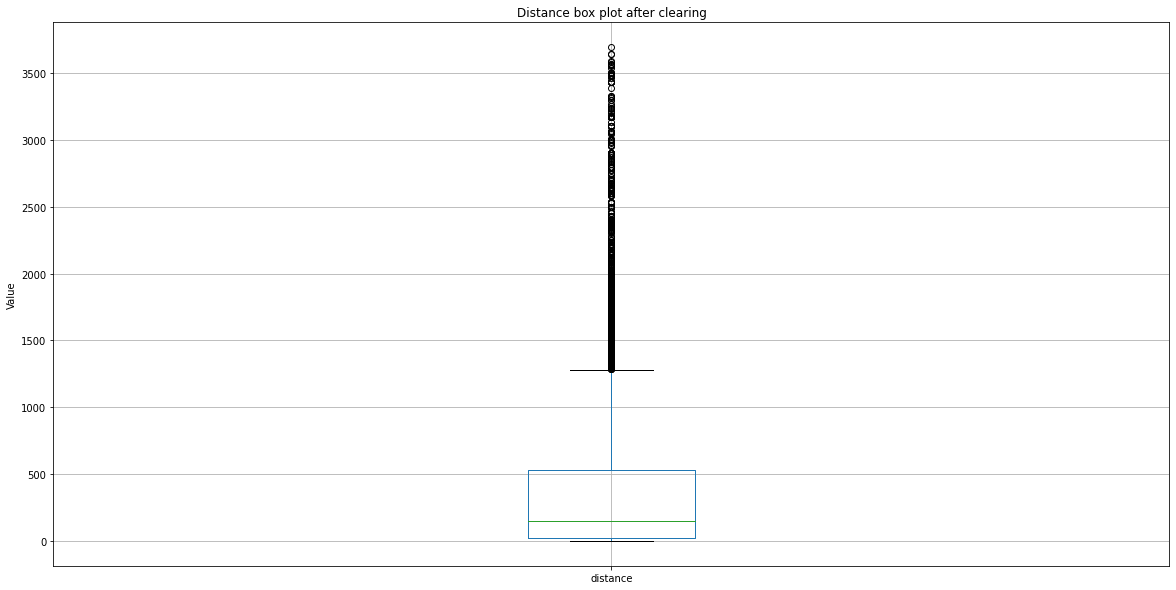

In [72]:
ax = X_train.boxplot(column='distance', figsize=(20, 10))

ax.set_ylabel('Value')
ax.set_title('Distance box plot after clearing')

plt.show()

In [73]:
X_train = X_train[X_train['vehicle_age'] < X_train['vehicle_age'].quantile(0.99)]

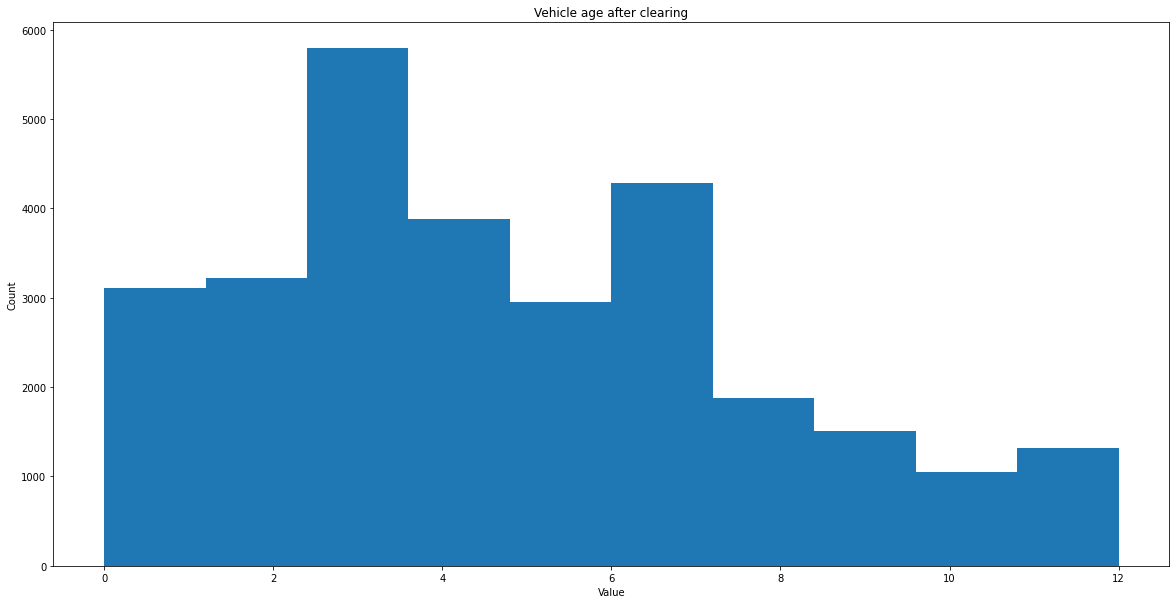

In [74]:
ax = X_train['vehicle_age'].plot.hist(figsize=(20, 10), title='Vehicle age after clearing')

ax.set_ylabel('Count')
ax.set_xlabel('Value')

plt.show()

In [75]:
y_train = y_train[X_train.index]

In [76]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28995 entries, 27002 to 13996
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              28995 non-null  float64
 1   intersection          28995 non-null  float64
 2   weather_1             28995 non-null  object 
 3   road_surface          28995 non-null  object 
 4   road_condition_1      28995 non-null  object 
 5   lighting              28995 non-null  object 
 6   party_sobriety        28995 non-null  object 
 7   vehicle_transmission  28995 non-null  object 
 8   vehicle_age           28995 non-null  float64
 9   collision_month_sin   28995 non-null  float64
 10  collision_month_cos   28995 non-null  float64
 11  collision_hour_sin    28995 non-null  float64
 12  collision_hour_cos    28995 non-null  float64
dtypes: float64(7), object(6)
memory usage: 3.1+ MB


Мы удалили выбросы в признаках `distance` и `vehicle_age`. Учебная выборка сократилась примерно на 2000 записей.

#### Кодирование и масштабирование признаков

Используем One-Hot Encoder для кодирования категориальных признаков, а количественные признаки отмасштабируем.

In [77]:
# 'intersection' не включаем в категориальные признаки, т.к. признак имеет только два значения - 1 и 0
cat_features = ['weather_1', 
                'road_surface', 
                'road_condition_1', 
                'lighting', 
                'party_sobriety', 
                'vehicle_transmission'
               ]
num_features = ['distance',
                'vehicle_age', 
                'collision_month_sin', 
                'collision_month_cos', 
                'collision_hour_sin', 
                'collision_hour_cos'
               ]

In [78]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [79]:
# Кодирование и масштабирование прризнаков
encoder = ce.one_hot.OneHotEncoder(cols=cat_features, return_df=True)

encoder.fit(X_train_copy)

X_train_copy = encoder.transform(X_train_copy)
X_test_copy = encoder.transform(X_test_copy)

scaler = StandardScaler()
scaler.fit(X_train_copy[num_features])

X_train_copy[num_features] = scaler.transform(X_train_copy[num_features])
X_test_copy[num_features] = scaler.transform(X_test_copy[num_features])

In [80]:
X_train_copy.head()

,distance,intersection,weather_1_1,weather_1_2,weather_1_3,weather_1_4,weather_1_5,weather_1_6,weather_1_7,road_surface_1,...,party_sobriety_4,party_sobriety_5,party_sobriety_6,vehicle_transmission_1,vehicle_transmission_2,vehicle_age,collision_month_sin,collision_month_cos,collision_hour_sin,collision_hour_cos
27002,1.273009,0.0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,-1.609881,-0.549263,-1.361296,-0.945406,1.149832
36592,-0.381446,0.0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0.089014,-0.549263,-1.361296,-1.141048,0.380324
26163,-0.529165,0.0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0.428793,-0.549263,-1.361296,0.697196,1.866900
7657,-0.676884,1.0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,-0.930323,-0.549263,-1.361296,-1.091290,-0.018004
13238,1.662987,0.0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,-0.590544,0.504039,-0.783951,-0.945406,-0.389185


In [81]:
X_test_copy.head()

,distance,intersection,weather_1_1,weather_1_2,weather_1_3,weather_1_4,weather_1_5,weather_1_6,weather_1_7,road_surface_1,...,party_sobriety_4,party_sobriety_5,party_sobriety_6,vehicle_transmission_1,vehicle_transmission_2,vehicle_age,collision_month_sin,collision_month_cos,collision_hour_sin,collision_hour_cos
5376,-0.498144,0.0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0.089014,0.504039,0.793385,1.583895,-0.389185
31332,-0.676884,1.0,1,0,0,0,0,0,0,1,...,1,0,0,1,0,1.108351,-0.549263,1.370730,-1.141048,0.380324
12180,0.883030,0.0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,1.448130,-0.549263,-1.361296,1.729778,-0.018004
24979,-0.614842,0.0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,-0.590544,0.889575,0.004717,1.583895,1.149832
26448,0.209431,0.0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,1.448130,0.504039,0.793385,-0.945406,1.149832


## Поиск лучшей модели

Для оценки моделей и решения задачи классификации будем использовать метрику F1-score. Наш датасет сильно несбалансирован и нам необходимо прогнозировать положительный класс (водитель виноват в ДТП). F1-score подойдёт для нашей задачи.

In [82]:
# Напишем функцию для поиска лучшей модели
def best_model_search_cv(model, params):
    grid = GridSearchCV(model, params, cv=5, n_jobs=-1, scoring='f1')
    grid.fit(X_train_copy, y_train)
    return grid.best_estimator_, grid.best_score_, grid.best_params_

### Логистическая регрессия 

In [83]:
# Параметры для первого запуска GridSearchCV
params = {
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [1000]
}

# Лучшие параметры, полученные после первого запуска GridSearchCV
params = {
    'solver': ['sag'],
    'max_iter': [1000]
}

estimator_lr = LogisticRegression(random_state=42, class_weight='balanced')

best_model_lr, best_score_lr, best_params_lr = best_model_search_cv(estimator_lr, params)

display(f'Best params: {best_params_lr}')
display(f'F1-score of the best model: {best_score_lr}')

"Best params: {'max_iter': 1000, 'solver': 'sag'}"

'F1-score of the best model: 0.5143280799305773'

### Случайный лес

In [84]:
# Параметры для первого запуска GridSearchCV
params = {
    'n_estimators': range(70, 101, 10),
    'max_depth': range(2, 11, 4),
    'min_samples_leaf': range(1, 4),
    'min_samples_split': range(2, 6, 2) 
}

# Лучшие параметры, полученные после первого запуска GridSearchCV
params = {
    'n_estimators': [90],
    'max_depth': [10],
    'min_samples_leaf': [3],
    'min_samples_split': [2] 
}

estimator_rf = RandomForestClassifier(random_state=42, class_weight='balanced')

best_model_rf, best_score_rf, best_params_rf = best_model_search_cv(estimator_rf, params)

display(f'Best params: {best_params_rf}')
display(f'F1-score of the best model: {best_score_rf}')

"Best params: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 90}"

'F1-score of the best model: 0.5280650919941404'

### LightGBM

In [85]:
# Параметры для первого запуска GridSearchCV
params = {
    'max_depth': [4, 6],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'subsample': [0.7, 0.8, 0.9],
    'min_child_samples': [1, 5, 10],
    'num_leaves': [40]
}

# Лучшие параметры, полученные после первого запуска GridSearchCV
params = {
    'max_depth': [6],
    'colsample_bytree': [0.7],
    'subsample': [0.7],
    'min_child_samples': [1],
    'num_leaves': [40]
}

estimator_lgb = lgb.LGBMClassifier(objective='binary', 
                              random_state=42)

best_model_lgb, best_score_lgb, best_params_lgb = best_model_search_cv(estimator_lgb, params)

display(f'Best params: {best_params_lgb}')
display(f'F1-score of the best model: {best_score_lgb}')

"Best params: {'colsample_bytree': 0.7, 'max_depth': 6, 'min_child_samples': 1, 'num_leaves': 40, 'subsample': 0.7}"

'F1-score of the best model: 0.5733446091555268'

### Вывод 

Было обучено 3 модели: логистическая регрессия, случайный лес и LightGBM. В результате были получены следующие показатели метрики F1-score:



In [86]:
display(f'F1-score')
display(f'Logistic Regression: {best_score_lr.round(5)}')
display(f'Random Forest: {best_score_rf.round(5)}')
display(f'LightGBM: {best_score_lgb.round(5)}')

'F1-score'

'Logistic Regression: 0.51433'

'Random Forest: 0.52807'

'LightGBM: 0.57334'

LightGBM показала наилучшие результаты.

## Проверка лучшей модели

In [87]:
# Проверим модель на тестовой выборке
best_model_lgb.fit(X_train_copy, y_train)
predictions = best_model_lgb.predict(X_test_copy)
f'F1-score value on the test sample: {f1_score(y_test, predictions)}'

'F1-score value on the test sample: 0.5705570484421527'

Наша LightGBM модель показала на тестовой выборке результаты, близкие к результатам на учебной выборке. 

In [88]:
# Сгенерируем отчёт по классификации
report = classification_report(y_test, predictions)
print('Classification report: \n', report)

Classification report: 
               precision    recall  f1-score   support

           0       0.58      0.75      0.65      7410
           1       0.68      0.49      0.57      7967

    accuracy                           0.62     15377
   macro avg       0.63      0.62      0.61     15377
weighted avg       0.63      0.62      0.61     15377



In [89]:
# Выведем матрицу ошибок
matrix = confusion_matrix(y_test, predictions)
print('Confusion matrix: \n', matrix)

Confusion matrix: 
 [[5536 1874]
 [4039 3928]]


По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:
* True Negative (истинно отрицательные прогнозы) - в левом верхнем углу;
* True Positive (истинно положительные) - в правом нижнем углу.
    
Вне главной диагонали — ошибочные варианты:
* False Positive (ложно положительные) - в правом верхнем углу;
* False Negative (ложно отрицательные) в левом нижнем углу.

В результате мы можем сказать, что наша модель дала довольно большое количество истинно отрицательных и истинно положительных прогнозов. Но так же было и довольно большое количество ложно отрицательных прогнозов - модель предсказывала, что ДТП не будет, в то время, как ДТП на самом деле было.

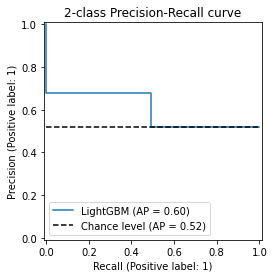

In [90]:
# Построим график полноты и точности

pr_curve = PrecisionRecallDisplay.from_predictions(y_test, predictions, name="LightGBM", plot_chance_level=True)

_ = pr_curve.ax_.set_title("2-class Precision-Recall curve")


Кривая precision-recall (точность-полнота) показывает компромисс между precision (точность) и recall (полнота) для различных пороговых значений. Большая площадь под кривой означает как высокую полноту, так и высокую точность, где высокая точность связана с низким уровнем ложноположительных результатов, а высокая полнота - с низким уровнем ложноотрицательных результатов.

Полнота выявляет, какую долю положительных ответов среди всех ответов выделила модель. Наша модель определила примерно 50% истинно положительных случаев.

Точность определяет, как много отрицательных ответов предсказала модель, пока предсказывала положительные. Наша модель предсказала примерно 70%. Высокая точность означает, что алгоритм возвращает больше релевантных результатов, чем нерелевантных.

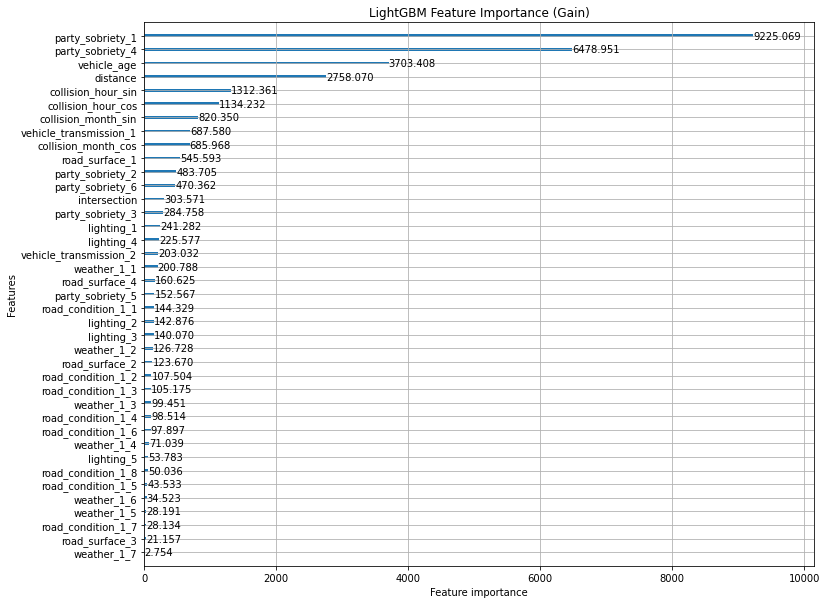

In [91]:
# Построим диаграмму важности признаков
lgb.plot_importance(best_model_lgb, importance_type="gain", figsize=(12,10), title="LightGBM Feature Importance (Gain)")
plt.show()

На графике важности признаков, явно предобладает признак `party_sobriety` (трезвость водителя). 

Вероятно, мы могли бы значительно снизить риск ДТП, если бы имели возможность проверить трезвость водителя перед поездкой. Возможно существуют какие-то портативные устройства, которые позволяют оценить трезвость водителя дистанционно и пригодные для установки внутри машины. Верифицировать, что именно водитель пользуется таким устройством можно с помощью камеры.

Так же весомую роль играет признак `vehicle_age` - возраст автомобиля (и связанный с этим износ) оказывает значительное влияние на шанс ДТП. Можно предположить, что более молодой автопарк положительно скажется на уменьшении частоты ДТП.

Важным оказался признак `distance` - расстояние до главной дороги в случаях ДТП. Рекомендовано дополнительное исследование данного признака, для выявления связи между ним и частотой ДТП.

Оценим один из минорных признаков: построим график важности признака `collision_hour_sin` для оценки ДТП.

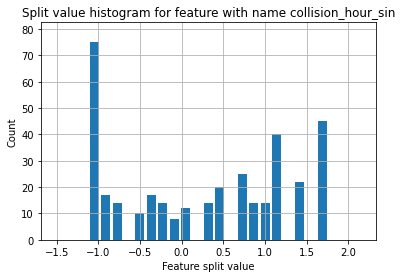

In [92]:
lgb.plot_split_value_histogram(best_model_lgb, 'collision_hour_sin')

plt.show()

Мы могли бы оснастить авто системой, которая по определенным паттернам движения руля могла бы распознавать засыпающего водителя. Так же можно оснастить авто камерой с системой распознавания лица / глаз для оценки состояния водителя. 

## Выводы

Мы обучили несколько моделей и нашли среди них лучшую: LightGBM с F1-score = 0.57937.

Создать адекватную модель, предсказывающую риск ДТП перед выдачей авто возможно, но требуется провести исследование по подбору необходимых признаков.

Качество предсказаний модели далеко от оптимальных 0.8-0.9. Вероятно имея более разнообразные и более сбалансированные исторические данные, мы могли бы предсказывать вероятность ДТП лучше.